In [13]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from myDataSet import *
from tqdm import tqdm

In [14]:
def accuracy(y_hat: torch.Tensor,
             y_actual: torch.Tensor) -> float:
    """
    Function for calculating the accuracy of 'y_hat' against 'y_actual'
    in terms of: nr. agreements / nr. comparisons.

     Parameters:
    - y_hat: 2D torch tensor of shape (nr. datapoints, nr. classes) only containing 1 and 0.
    - y_actual: 2D torch tensor of shape (nr. datapoints, nr. classes) only containing 1 and 0.

     Returns:
    - _accuracy: float in range (0,1).
    """
    assert y_hat.shape == y_actual.shape, f'Inputs are not of matching shapes.'
    _nr_equals = torch.sum(y_hat*y_actual)
    _accuracy = _nr_equals/y_hat.shape[0]
    return _accuracy

In [15]:
class DataPrep:
    def __init__(self, dataset: MyCustomImageDataset,
                    batch_size: int = 20,
                 data_fraction: float = 0.1,
                 test_fraction: float = 0.2) -> None:
        self.X, self.Y = dataset.X.to(torch.float32), list(dataset.Y)
        self.batch_size = batch_size
        self.test_fraction = test_fraction
        self.data_fraction = data_fraction

        self.label_dict = None
        self.train_X, self.train_Y = None, None
        self.test_X, self.test_Y   = None, None


    def prepare(self):
        # One-hot encoding labels
        self.Y = self.one_hot(self.Y)

        # Normalizing pixels values
        self.X = self.normalize_pixels(self.X)

        # Batching data in batches
        self.X, self.Y = self.batch_data(data=self.X,
                                       labels=self.Y,
                                   batch_size=self.batch_size,
                                    randomize=True)

        # Picking out portion size according to 'data_fraction'
        print("Initial nr. of batches: ", len(self.X))
        self.X, self.Y = self.X[:int(self.data_fraction*len(self.X))], self.Y[:int(self.data_fraction*len(self.Y))]
        print("Final nr. of batches: ", len(self.X))

        # Splitting into test and training set according to 'test_fraction'
        self.test_X, self.test_Y = self.X[:int(self.test_fraction*len(self.X))], self.Y[:int(self.test_fraction*len(self.Y))]
        self.train_X, self.train_Y = self.X[len(self.test_X):], self.Y[len(self.test_Y):]

    @staticmethod
    def batch_data(data: torch.Tensor,
                   labels: torch.Tensor,
                   batch_size: int,
                   randomize: bool = False) -> tuple[list[torch.Tensor],list[torch.Tensor]]:
        """
        Takes the input data, shuffles it randomly and repacks it in batches of
        'batch_size'. If len(labels) % batch_size != 0, the final number of
        batches is rounded down.

         Parameters:
        - data: A torch Tensor of shape (nr. data points, nr. channels, height, width).
        - labels: Either tuple, list or 1d numpy array containing the labels for the data.
        - batch_size: The number of data points contained within each batch.
        - randomize: A boolean determining whether the data is randomly shuffled.

         Returns:
        - batches: A tuple of (X_batches, Y_batches)
        """
        assert type(data) is torch.Tensor and len(data.shape) == 4
        assert type(labels) is torch.Tensor and len(labels.shape) == 2

        _indices = [i for i in range(len(labels))]
        if randomize:
            _indices = torch.randperm(len(_indices))
            _indices = _indices.tolist()

        _X_batches, _Y_batches = [], []
        for _batch in range(len(labels) // batch_size):
            _i= _indices[batch_size*_batch : batch_size*(_batch+1)]
            _X_batches.append(data[_i,::])
            _Y_batches.append(labels[_i,::])

        batches = _X_batches, _Y_batches
        return batches

    def one_hot(self, labels: tuple | list) -> torch.Tensor:
        """
        Creates a one-hot encoding of given labels.

         Parameters:
        - labels: tuple or list containing labels.

         Returns:
        - one_hot_Y: 2D torch Tensor of shape (nr. data points, nr. classes).
        """
        assert type(labels) is tuple or type(labels) is list, f'Unrecognized labels type: should be tuple or list.'
        # Creating map from label to integer
        self.label_dict = {}
        for class_idx, label in enumerate(set(labels)):
            self.label_dict[label] = class_idx
        # Calculating Number of data points x Nr of classes one-hot encoding of Y
        nr_labels = len(list(labels))
        nr_unique_labels = len(list(self.label_dict.keys()))
        one_hot_Y = torch.zeros(size=(nr_labels, nr_unique_labels))
        for i, label in enumerate(labels):
            one_hot_Y[i][self.label_dict[label]] = 1
        return one_hot_Y

    @staticmethod
    def normalize_pixels(data: torch.Tensor) -> torch.Tensor:
        """
        Void type function normalizing every value: (0,255) -> (0,1), in input tensor.

         Parameters:
        - data: 4D torch tensor of data of shape (nr. datapoints, nr. channels, height, width)

        """
        _PIXEL_MAX = 255
        for data_point in range(data.shape[0]):
            data[data_point] *= 1.0/_PIXEL_MAX
        return data

In [16]:
class NeuralNet(torch.nn.Module):

    def __init__(self, channels_in: int,
                        nr_classes: int,
                 input_dimensions: tuple[int,int]) -> None:
        super(NeuralNet, self).__init__()
        self.input_dim = input_dimensions
        self.nr_classes = nr_classes

        # layer 1: convolutional layer
        self.conv1 = torch.nn.Conv2d(in_channels=channels_in,
                                    out_channels=6,
                                     kernel_size=(5,5),
                                          stride=(1,1),
                                         padding=(0,0))
        # activation function
        self.activation1 = torch.nn.ReLU()
        object_dim1 = self.output_dim(self.input_dim,
                                      self.conv1.kernel_size,
                                      self.conv1.stride,
                                      self.conv1.padding)
        #--------------------------------------#

        # layer 2: pooling layer
        self.pool1 = torch.nn.AvgPool2d(kernel_size=(2,2),
                                             stride=(1,1),
                                             padding=(0,0))

        object_dim2 = self.output_dim(object_dim1,
                                      self.pool1.kernel_size,
                                      self.pool1.stride,
                                      self.pool1.padding)

        #--------------------------------------#

        # layer 3: convolutional layer
        self.conv2 = torch.nn.Conv2d(in_channels=6,
                                    out_channels=16,
                                     kernel_size=5,
                                          stride=(1,1),
                                         padding=(0,0))
        # activation function
        self.activation2 = torch.nn.ReLU()
        object_dim3 = self.output_dim(object_dim2,
                                      self.conv2.kernel_size,
                                      self.conv2.stride,
                                      self.conv2.padding)
        #--------------------------------------#

        # layer 4: pooling layer
        self.pool2 = torch.nn.AvgPool2d(kernel_size=(2,2),
                                             stride=(1,1),
                                             padding=(0,0))

        object_dim4 = self.output_dim(object_dim3,
                                      self.pool2.kernel_size,
                                      self.pool2.stride,
                                      self.pool2.padding)
        # flattening
        self.flatten = torch.nn.Flatten(start_dim=1,end_dim=-1)

        #--------------------------------------#

        # layer 5: fully connected layer (lazy means input dim is automatically inferred)
        in_vector_length = self.conv2.out_channels*object_dim4[0]*object_dim4[1]
        self.lin1 = torch.nn.Linear(in_features=in_vector_length,
                                    out_features=120)

        # activation function
        self.activation3 = torch.nn.ReLU()

        #--------------------------------------#

        # layer 6: fully connected layer (lazy means input dim is automatically inferred)
        self.lin2 = torch.nn.Linear(in_features=self.lin1.out_features,
                                    out_features=self.nr_classes)


    @staticmethod
    def output_dim(data_size: tuple[int, int],
                   kernel_size: tuple[int, int],
                   stride_size: tuple[int, int] = (1,1),
                   padding_size: tuple[int, int] = (0,0)) -> tuple[int, int]:
        """
        Calculates output shape of array after convolution w. specific
        kernel, padding and stride.

         Parameters:
        - data_size: tuple containing dimension of 2D input array.
        - kernel_size: tuple containing dimension of 2D kernel.
        - stride_size: tuple containing dimension of 2D stride.
        - padding_size: tuple containing dimension of 2D padding.

         Returns:
        - output_dimensions: tuple containing dimension of resulting 2D array.
        """

        out_height = ((data_size[0] - kernel_size[0] + 2 * padding_size[0]) // stride_size[0]) + 1
        out_width = ((data_size[1] - kernel_size[1] + 2 * padding_size[1]) // stride_size[1]) + 1

        output_dimensions = (out_height, out_width)
        return output_dimensions

    def predict(self, forwarded_data:torch.Tensor) -> torch.Tensor:
        """
        Takes the raw estimate from a forward pass (nr. data points, nr. classes)
        and sets the highest val in each row 1 and the rest zero.

         Parameters:
        - forwarded_data: torch.Tensor of shape (nr. data points, nr. classes)

         Returns:
        - _prediction: torc.Tensor of shape (nr. data points, nr. classes)

        """
        assert forwarded_data.shape[1] == self.nr_classes, f'Forwarded data should be of shape (nr. data points, nr. classes).'
        assert len(forwarded_data.shape) == 2, f' Forwarded data should be a 2D tensor.'
        _prediction = torch.zeros(size=forwarded_data.shape)
        for row in range(forwarded_data.shape[0]):
            _prediction[row][torch.argmax(forwarded_data[row])] = 1
        return _prediction

    def forward(self, data):
        assert len(data.shape) == 4, f'Shape of X should be (nr. data points, nr. channels, height, width)'
        data = self.conv1(data)
        data = self.activation1(data)
        data = self.pool1(data)
        data = self.conv2(data)
        data = self.activation2(data)
        data = self.pool2(data)
        data = self.flatten(data)
        data = self.lin1(data)
        data = self.activation3(data)
        data = self.lin2(data)
        return data


def train(model: NeuralNet,
          train_data_batches: list[torch.Tensor],
          train_labels_batches: list[torch.Tensor],
          test_data_batches: list[torch.Tensor],
          test_labels_batches: list[torch.Tensor],
          epochs: int = 10) -> tuple[list,list,list,list]:

    _optimizer = torch.optim.SGD(params=model.parameters(),
                                 lr=0.001,
                                 momentum=0.9)
    _loss_function = torch.nn.CrossEntropyLoss()

    _train_accuracies, _train_losses = [], []
    _test_accuracies, _test_losses = [], []
    for epoch in tqdm(range(epochs)):
        _counter = 0
        _batch_train_acc, _batch_train_loss = 0.0, 0.0
        _batch_test_acc,  _batch_test_loss = 0.0, 0.0
        # Training against training data
        for x_batch, y_batch in zip(train_data_batches,train_labels_batches):
            # Ensure that parameter gradients are 0.
            _optimizer.zero_grad()
            # Forward pass
            _y_hat = model.forward(x_batch)
            assert _y_hat.shape[0] == train_labels_batches[0].shape[0]
            assert _y_hat.shape[1] == model.nr_classes
            # Loss calculation + backprop + optimization
            _loss = _loss_function(_y_hat,y_batch)
            _loss.backward()
            _optimizer.step()
            # Saving losses and accuracies
            _batch_train_acc += accuracy(model.predict(_y_hat),y_batch)
            _batch_train_loss += _loss.item()
            _counter += 1
        _train_accuracies.append(_batch_train_acc/_counter)
        _train_losses.append(_batch_train_loss/_counter)
        # Testing model on test data
        for x_batch, y_batch in zip(test_data_batches,test_labels_batches):
            # Forward pass
            _y_hat = model.forward(x_batch)
            assert _y_hat.shape[0] == train_labels_batches[0].shape[0]
            assert _y_hat.shape[1] == model.nr_classes
            # Loss calculation
            _loss = _loss_function(_y_hat,y_batch)
            # Saving losses and accuracies
            _batch_test_acc += accuracy(model.predict(_y_hat),y_batch)
            _batch_test_loss += _loss.item()
        _test_accuracies.append(_batch_test_acc/_counter)
        _test_losses.append(_batch_test_loss/_counter)
    return _train_accuracies, _train_losses, _test_accuracies, _test_losses


In [17]:
# Set up the dataset.
image_directory = "Insects"
annotations_file_directory = "insects.csv"
dataset = MyCustomImageDataset(annotations_file_directory, image_directory)


# Preparing data for learning (normalization, one-hot encoding and batching)
my_batch_size, my_data_fraction, my_test_fraction = 4, 0.1, 0.2
prepped_data = DataPrep(dataset=dataset,
                        batch_size=my_batch_size,
                        data_fraction=my_data_fraction,
                        test_fraction=my_test_fraction)
prepped_data.prepare()
my_X_train_batches, my_Y_train_batches = prepped_data.train_X, prepped_data.train_Y
my_X_test_batches, my_Y_test_batches = prepped_data.test_X, prepped_data.test_Y
print("Shape of single batch: ",my_X_train_batches[0].shape)

Initial nr. of batches:  181
Final nr. of batches:  18
Shape of single batch:  torch.Size([4, 3, 520, 520])


In [18]:
# Creating instance of neural network
my_nr_channels = my_X_train_batches[0].shape[1]
my_nr_classes = my_Y_train_batches[0].shape[1]
my_input_dimensions = (my_X_train_batches[0].shape[2], my_X_train_batches[0].shape[3])

my_net = NeuralNet(channels_in=my_nr_channels,
                   nr_classes=my_nr_classes,
                   input_dimensions=my_input_dimensions)

In [19]:
train_accuracies, train_losses, test_accuracies, test_losses = train(model=my_net,
                                                        train_data_batches=my_X_train_batches,
                                                      train_labels_batches=my_Y_train_batches,
                                                         test_data_batches=my_X_test_batches,
                                                       test_labels_batches=my_Y_test_batches,
                                                                    epochs=20)

100%|██████████| 20/20 [10:36<00:00, 31.84s/it]


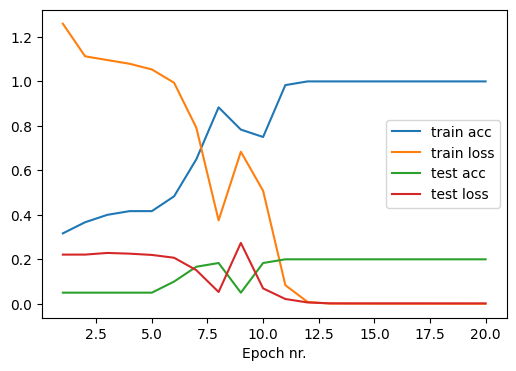

In [20]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
epochs = [i+1 for i in range(len(train_accuracies))]
ax.plot(epochs,train_accuracies,label="train acc")
ax.plot(epochs,train_losses,label="train loss")
ax.plot(epochs,test_accuracies,label="test acc")
ax.plot(epochs,test_losses,label="test loss")
ax.set_xlabel("Epoch nr.")
ax.legend()
plt.show()

In [21]:
def test_model(model: NeuralNet,
               data: DataPrep,
               nr_batches: int) -> None:
    # Generating random indices
    rand_indices = []
    while len(rand_indices) < nr_batches:
        _rand_int = torch.randint(low=0,high=len(data.Y),size=(1,)).item()
        if _rand_int not in rand_indices:
            rand_indices.append(_rand_int)
    # Predicting w. model and checking against true labels
    batch_counter = 1
    correct_counter = 0
    for _index in rand_indices:
        mod = model.forward(data.X[_index])
        y_hat  = model.predict(mod)
        y_real = data.Y[_index]
        print("\n ---  Random Batch: ", batch_counter, " ---")
        for _data_point in range(y_hat.shape[0]):
            pred = list(data.label_dict.keys())[torch.where(y_hat[_data_point]==1)[0]]
            actual = list(data.label_dict.keys())[torch.where(y_real[_data_point]==1)[0]]
            print("  ##| Prediction: ", pred," |--| Actual: ",actual," |##")
            if pred == actual:
                correct_counter += 1
        batch_counter += 1
    print("\n #####| ", correct_counter, "/", batch_counter * data.batch_size, " predicted correctly |#####")

In [22]:
test_model(my_net,prepped_data,6)


 ---  Random Batch:  1  ---
  ##| Prediction:  Panurgus banksianus  |--| Actual:  Panurgus banksianus  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##

 ---  Random Batch:  2  ---
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Panurgus banksianus  |--| Actual:  Panurgus banksianus  |##
  ##| Prediction:  Panurgus banksianus  |--| Actual:  Panurgus banksianus  |##
  ##| Prediction:  Andrena fulva  |--| Actual:  Andrena fulva  |##

 ---  Random Batch:  3  ---
  ##| Prediction:  Andrena fulva  |--| Actual:  Andrena fulva  |##
  ##| Prediction:  Panurgus banksianus  |--| Actual:  Panurgus banksianus  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctati

[8, 9]